### Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
#from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
import scipy.stats as stats
from collections import Counter
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import statsmodels.api as sm
matplotlib.style.use('ggplot')
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 10)
rcParams['axes.facecolor'] = "w"
rcParams['grid.color'] = "gray"
rcParams['grid.linewidth'] = 0.5

In [3]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

### Helper functions

In [4]:
#--------  fill_knn
#input: missing_df (nx2 dataframe, some rows have missing y vals), 
#       full_df (nx2 dataframe, all rows have correct y vals), 
#       no_y_ind (indices of rows missing_df in with missing y values), 
#       with_y_ind (indices of rows missing_df in with out missing y values), 
#       k (integer)
#output: predicted_df (dataframe), r (float)

def fill_knn(missing_df, full_df, no_y_ind, with_y_ind, k):
    #spliting data into train/test and preparing data in array form
    
    #training set
    x_train = missing_df.loc[with_y_ind, 'x'].values
    x_train = x_train.reshape((len(with_y_ind), 1)) #make this array 2D (row, column)
    y_train = missing_df.loc[with_y_ind, 'y'].values
    
    #training set
    x_test = missing_df.loc[no_y_ind, 'x'].values
    x_test = x_test.reshape((len(no_y_ind), 1)) #make this array 2D (row, column)
    y_test = full_df.loc[no_y_ind, 'y'].values
    
    #fit knn model
    neighbours = KNN(n_neighbors=k)
    neighbours.fit(x_train, y_train)
    
    #predict y-values
    predicted_y = neighbours.predict(x_test)
    
    #score predictions
    r = neighbours.score(x_test, y_test)
    
    #fill in missing y-values
    predicted_df = missing_df.copy()
    predicted_df.loc[no_y_ind, 'y'] = pd.Series(predicted_y, index=no_y_ind)
    
    return predicted_df, r

In [5]:
from sklearn.feature_extraction import DictVectorizer
 
def encode_onehot(df, cols):
    """
    One-hot encoding is applied to columns specified in a pandas DataFrame.
    
    """
    vec = DictVectorizer()
    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df

In [7]:
def clean_column_names(dataset):
    '''
    
    '''
    colnames = [" ".join(str.strip(x).split()).replace(' ','_') for x in dataset.columns]
    dataset.columns = colnames
    
    
    return dataset



### Loading the dataset

In [8]:
data_health_condition = pd.read_stata('ncds_archived_data_cfs_and_ibs_outcomes.dta')

In [9]:
data_health_condition.head()

,ncdsid,me,ibsoriginal,mal01backache,mal02tired,mal04headaches,mal06sleepingdifficulties,mal23rheumatism,ghqconcentration,cflikesymptoms,...,infecillness16y,childactive7,sport11,outdoorsport16,indoorsport16,sport23,exercisejob33,sport33,physicaljob42,sport42
0,N10001N,no,no,no,yes,yes,no,no,no,1.0,...,0.0,normally active,most days,often,sometimes,no sport last 4 wks,no exercise,2-3 days a week,moderate amount,4-5 days a week
1,N10002P,no,no,no,no,no,no,no,no,0.0,...,0.0,normally active,hardly ever,hardly ever/no chance,hardly ever/no chance,no sport last 4 wks,no exercise,once a week,moderate amount,every day
2,N10003Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,normally active,hardly ever,hardly ever/no chance,hardly ever/no chance,NaN,NaN,NaN,NaN,NaN
3,N10004R,no,no,no,no,no,no,no,no,0.0,...,0.0,normally active,most days,often,sometimes,no sport last 4 wks,NaN,once a week,moderate amount,every day
4,N10005S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,over active,sometimes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data_main = pd.read_stata('ncds0123.dta',convert_categoricals=False)

In [11]:
data_main.shape

(18558, 1765)

In [12]:
data_main.head()

,ncdsid,n622,n0region,n1region,n2region,n3region,n553,n545,n520,n490,...,n1849,dvht07,dvht11,dvht16,dvrwt07,dvrwt11,dvrwt16,dvwt07,dvwt11,dvwt16
0,N10001N,2.0,9.0,9.0,9.0,9.0,23.0,4.0,2.0,12.0,...,-1.0,1.219000,1.473,1.599999,110.347992,98.192993,105.056000,25.854996,37.648987,56.019989
1,N10002P,1.0,9.0,8.0,8.0,8.0,34.0,4.0,5.0,1.0,...,-1.0,1.346000,-1.000,-1.000000,90.865997,-1.000000,-1.000000,26.308990,-1.000000,-1.000000
2,N10003Q,1.0,4.0,4.0,4.0,4.0,34.0,4.0,10.0,1.0,...,-1.0,1.320999,1.499,1.879999,87.959991,96.404999,89.382996,24.493988,38.101990,66.679993
3,N10004R,2.0,1.0,1.0,1.0,1.0,26.0,4.0,11.0,1.0,...,-1.0,1.294999,1.511,1.629999,105.161987,111.588989,132.054993,28.122986,45.813995,72.799988
4,N10005S,2.0,10.0,10.0,10.0,10.0,25.0,4.0,1.0,3.0,...,-1.0,1.346000,-1.000,-1.000000,129.382996,-1.000000,-1.000000,37.648987,-1.000000,-1.000000


In [47]:
extended_df = pd.merge(data_main, data_health_condition, on='ncdsid', how='outer')
print (extended_df.shape)
extended_df.head()

(18558, 1962)


,ncdsid,n622,n0region,n1region,n2region,n3region,n553,n545,n520,n490,...,infecillness16y,childactive7,sport11,outdoorsport16,indoorsport16,sport23,exercisejob33,sport33,physicaljob42,sport42
0,N10001N,2.0,9.0,9.0,9.0,9.0,23.0,4.0,2.0,12.0,...,0.0,normally active,most days,often,sometimes,no sport last 4 wks,no exercise,2-3 days a week,moderate amount,4-5 days a week
1,N10002P,1.0,9.0,8.0,8.0,8.0,34.0,4.0,5.0,1.0,...,0.0,normally active,hardly ever,hardly ever/no chance,hardly ever/no chance,no sport last 4 wks,no exercise,once a week,moderate amount,every day
2,N10003Q,1.0,4.0,4.0,4.0,4.0,34.0,4.0,10.0,1.0,...,0.0,normally active,hardly ever,hardly ever/no chance,hardly ever/no chance,NaN,NaN,NaN,NaN,NaN
3,N10004R,2.0,1.0,1.0,1.0,1.0,26.0,4.0,11.0,1.0,...,0.0,normally active,most days,often,sometimes,no sport last 4 wks,NaN,once a week,moderate amount,every day
4,N10005S,2.0,10.0,10.0,10.0,10.0,25.0,4.0,1.0,3.0,...,0.0,over active,sometimes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Extract Epilepsy and Seizure information

 - 1-	Our target response variable Y is a column with two values 1 and 0. 

 - 2-	Y = 0 if patient had seizure before  but didn’t end with epileptic condition.

 - 3-	Y = 1 if patient had seizure before  and end with epileptic condition.

 - 4-	Let’s say Y_Seizure variable represent patient had seizure before.

 - 5-	Let’s say Y_Epilepsy variable represent patient is epileptic

 - 6-	So in order to calculate Y we need to calculate Y_Seizure and Y_Epilepsy

 - 7-	In our data set we have three columns already calculated for epilepsy7,epilepsy11, and epilepsy16 

 - 8-	Y_epilepsy = 1  if epilepsy7=1 or epilepsy11 =1 or  epilepsy16 = 1

 - 9-	Now In order to calculate Y_Seizure we will follow the same idea by create three variable seizure7, seizure11, seizure16

 - 10-	For example seizure7 =1 if the patient had any seizure from age 0 to age 7

 - 11-	In the dataset they calculate for epilepsy7,epilepsy11, and epilepsy16  as condition of many other variables , for example they calculated epilepsy16 =1 if ((n1307=1) OR (n1308=1) OR (n1307=2) OR (n1308=2) OR (n1307=3) OR (n1308=3)) Epilepsy11=1.

 - 12-	We will following the same approach to calculate seizure7, seizure11, seizure16

 - 13-	For example seizure7 will equal to 1 if 
 
 (extended_df.n1831 == 3)    # 0 Illness noted in PMS-MC1:3              Value = 3.0    Label = Convulsions etc.

| (extended_df.n1832 == 3)    # 0 Illness noted in PMS-MC2:3              Value = 3.0    Label = Convulsions etc.

| (extended_df.n1833 == 3)    # 0 Illness noted in PMS-MC3:3              Value = 3.0    Label = Convulsions etc.

| (extended_df.n274  == 2)    # 1P Fit or convulsion in 1st year of life  Value = 2.0    Label = Yes

| (extended_df.n275  == 2)    # 1P Fit or convulsion after 1st year       Value = 2.0    Label = Yes

| (extended_df.n390 == 10)    # 1M Reason for Special Education MC1:3     Value = 10.0   Label = Epileptic

| (extended_df.n391 == 10)    # 1M Reason for Special Education MC2:3     Value = 10.0   Label = Epileptic

| (extended_df.n392 == 10)    # 1M Reason for Special Education MC3:3     Value = 10.0   Label = Epileptic


         

 - 14-	We will calculate seizure11 and seizure16 using the same approach ( I will send the equation soon today)

 - 15-	Y_Seizure = 1 if seizure7= 1 or  seizure11 = 1  or seizure16 =1

 - 16-	For Y_Seizure = 0   ---> remove the row for the dataset

 - 17-	For Y_seizure=1  and Y_Epilepsy = 0   --->  Y= 0

 - 18-	For Y_seizure=1  and Y_Epilepsy = 1   --->  Y= 1

In [48]:
epilepsy_response=extended_df[['epilepsy7','epilepsy11','epilepsy16' ]]

In [49]:
epilepsy_response.shape

(18558, 3)

In [50]:
epilepsy_response['seizure7']=((extended_df.n1831 == 3)    # 0 Illness noted in PMS-MC1:3              Value = 3.0   Label = Convulsions etc.
                      | (extended_df.n1832 == 3)    # 0 Illness noted in PMS-MC2:3              Value = 3.0   Label = Convulsions etc.
                      | (extended_df.n1833 == 3)    # 0 Illness noted in PMS-MC3:3              Value = 3.0   Label = Convulsions etc.
                      | (extended_df.n274  == 2)    # 1P Fit or convulsion in 1st year of life  Value = 2.0    Label = Yes
                      | (extended_df.n275  == 2)    # 1P Fit or convulsion after 1st year       Value = 2.0	   Label = Yes
                      | (extended_df.n390 == 10)    # 1M Reason for Special Education MC1:3     Value = 10.0   Label = Epileptic
                      | (extended_df.n391 == 10)    # 1M Reason for Special Education MC2:3     Value = 10.0   Label = Epileptic
                      | (extended_df.n392 == 10)    # 1M Reason for Special Education MC3:3     Value = 10.0   Label = Epileptic
                      | ((extended_df.n1314 >=0) & (extended_df.n1314 <= 7))    # 2P Age at most recent epilepsy attack
                      | ((extended_df.n1317 >=0) & (extended_df.n1317 <= 7))     # 2P Age at 1st epilepsy attack
                      | (extended_df.n1502 ==2)      # 2M Has child ever had convulsions
                      | (extended_df.n1502 ==4)      # 2M Has child ever had convulsions
                      | ((extended_df.n2615 >= 1) & (extended_df.n2615 <= 4))   # 3P When convulsions,fits 1st occured
                      | ((extended_df.n2616 >= 1) & (extended_df.n2616 <= 4))  #3P Convulsions-most recent occurrence                      

                     )*1
epilepsy_response.seizure7.value_counts()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    17590
1      968
Name: seizure7, dtype: int64

In [51]:
epilepsy_response['seizure11']=(  (extended_df.n1477 == 7)    # 2M Reason for special education - MC1:3    Value = 7.0	Label = Epileptic
                       | (extended_df.n1478 == 7)    # 2M Reason for special education - MC2:3    Value = 7.0	Label = Epileptic
                       | (extended_df.n1479 == 7)    # 2M Reason for special education - MC3:3    Value = 7.0	Label = Epileptic
                       | (extended_df.n1307 == 1)     # 2P Has child had epilepsy attacks-MC 1:3
                       | (extended_df.n1307 == 2)     # 2P Has child had epilepsy attacks-MC 1:3
                       | (extended_df.n1307 == 3)     # 2P Has child had epilepsy attacks-MC 1:3
                       | (extended_df.n1308 == 1)     # 2P Has child had epilepsy attacks-MC 2:3
                       | (extended_df.n1308 == 2)     # 2P Has child had epilepsy attacks-MC 2:3
                       | (extended_df.n1308 == 3)     # 2P Has child had epilepsy attacks-MC 2:3
                       | (extended_df.n1309 == 1)     # 2P Has child had epilepsy attacks-MC 3:3
                       | (extended_df.n1309 == 2)     # 2P Has child had epilepsy attacks-MC 3:3
                       | (extended_df.n1309 == 3)     # 2P Has child had epilepsy attacks-MC 3:3
                       | ((extended_df.n1314 >= 8) & (extended_df.n1314 <= 11))   # 2P Age at most recent epilepsy attack
                       | ((extended_df.n1317 >= 8) & (extended_df.n1317 <= 11))   # 2P Age at 1st epilepsy attack
                       | (extended_df.n1321 == 8)    # 2P Reason for absence from school-MC 1:5   Value = 8.0	Label = Convulsions
                       | (extended_df.n1322 == 8)    # 2P Reason for absence from school-MC 2:5   Value = 8.0	Label = Convulsions
                       | (extended_df.n1323 == 8)    # 2P Reason for absence from school-MC 3:5   Value = 8.0	Label = Convulsions
                       | (extended_df.n1324 == 8)    # 2P Reason for absence from school-MC 4:5   Value = 8.0	Label = Convulsions
                       | (extended_df.n1325 == 8)    # 2P Reason for absence from school-MC 5:5   Value = 8.0	Label = Convulsions
                       | (extended_df.n1337 == 1)    # 2P Reason for prescription  M:C 1-2        Value = 1.0	Label = Convulsions etc.
                       | (extended_df.n1338 == 8)    # 2P Reason for prescription  M:C 2-2        Value = 1.0	Label = Convulsions etc.
                       | (extended_df.n1394 == 2)    # 2P Ever seen specialist-convulsions,fits   Value = 2,3,5
                       | (extended_df.n1394 == 3)    # 2P Ever seen specialist-convulsions,fits   Value = 2,3,5
                       | (extended_df.n1394 == 5)    # 2P Ever seen specialist-convulsions,fits   Value = 2,3,5
                       | (extended_df.n1502 == 3)     # 2M Has child ever had convulsions
                       | (extended_df.n1502 == 4)     # 2M Has child ever had convulsions
                       | (extended_df.n2615 == 5)    # 3P When convulsions,fits 1st occured  Value = 5.0	Label = Between 7&11 yrs
                       | (extended_df.n2616 == 5)    # 3P Convulsions-most recent occurrence Value = 5.0	Label = Between 7&11 yrs                       
                     )*1
epilepsy_response.seizure11.value_counts()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    17925
1      633
Name: seizure11, dtype: int64

In [52]:
epilepsy_response['seizure16']=(  (extended_df.n1893 == 8)    # 3M Category of child's handicap MC1:3   Value = 8.0	Label = Epileptic
                       | (extended_df.n1894 == 8)    # 3M Category of child's handicap MC2:3   Value = 8.0	Label = Epileptic
                       | (extended_df.n1895 == 8)    # 3M Category of child's handicap MC3:3   Value = 8.0	Label = Epileptic
                       | (extended_df.n2663 == 7)    # 3P Nature of child-s disability-MC 1:5   Value = 7.0	Label = Epilepsy
                       | (extended_df.n2664 == 7)    # 3P Nature of child-s disability-MC 2:5   Value = 7.0	Label = Epilepsy
                       | (extended_df.n2665 == 7)    # 3P Nature of child-s disability-MC 3:5   Value = 7.0	Label = Epilepsy
                       | (extended_df.n2666 == 7)    # 3P Nature of child-s disability-MC 4:5   Value = 7.0	Label = Epilepsy
                       | (extended_df.n2667 == 7)    # 3P Nature of child-s disability-MC 5:5   Value = 7.0	Label = Epilepsy
                       | (extended_df.n1904 == 17)     # 3M Reason for hosp admiss last 12 mnths Value = 17.0	Label = Epilepsy
                       | (extended_df.n1910 == 17)     # 3M Reason hosp outpatient last yr      Value = 17.0	Label = Epilepsy
                       | (extended_df.n2032 == 3)     # 3M Epilepsy  Value = 3.0	Label = Cond,no handcp
                       | (extended_df.n2032 == 4)     # 3M Epilepsy  Value = 4.0	Label = Slight handicap
                       | (extended_df.n2032 == 5)     # 3M Epilepsy  Value = 5.0	Label = Moderate handicp
                       | (extended_df.n2032 == 6)     # 3M Epilepsy  Value = 6.0	Label = Severe handicap
                       | (extended_df.n2032 == 7)     # 3M Epilepsy  Value = 7.0	Label = Cond,DK degree
                       | (extended_df.n2554 == 3)     # 3P Reason for absence from school-MC 1:6   Value = 11.0	Label = Convulsions,fits
                       | (extended_df.n2555 == 3)     # 3P Reason for absence from school-MC 2:6   Value = 11.0	Label = Convulsions,fits
                       | (extended_df.n2556 == 3)     # 3P Reason for absence from school-MC 3:6   Value = 11.0	Label = Convulsions,fits
                       | (extended_df.n2557 == 3)     # 3P Reason for absence from school-MC 4:6   Value = 11.0	Label = Convulsions,fits
                       | (extended_df.n2558 == 3)     # 3P Reason for absence from school-MC 5:6   Value = 11.0	Label = Convulsions,fits
                       | (extended_df.n2559 == 3)     # 3P Reason for absence from school-MC 6:6   Value = 11.0	Label = Convulsions,fits
                       | (extended_df.n2598 == 7)    # 3P Hospital admissions,general-MC 1:4  Value = 7.0	Label = Convulsions
                       | (extended_df.n2599 == 7)    # 3P Hospital admissions,general-MC 1:4  Value = 7.0	Label = Convulsions
                       | (extended_df.n2600 == 7)    # 3P Hospital admissions,general-MC 1:4  Value = 7.0	Label = Convulsions
                       | (extended_df.n2601 == 7)    # 3P Hospital admissions,general-MC 1:4  Value = 7.0	Label = Convulsions
                       | (extended_df.n2603 == 10)   # 3P Hosp outpatient,diagnosed cond-MC 1:6   Value = 10.0	Label = Convulsions
                       | (extended_df.n2604 == 10)   # 3P Hosp outpatient,diagnosed cond-MC 2:6   Value = 10.0	Label = Convulsions
                       | (extended_df.n2605 == 10)   # 3P Hosp outpatient,diagnosed cond-MC 3:6   Value = 10.0	Label = Convulsions
                       | (extended_df.n2606 == 10)   # 3P Hosp outpatient,diagnosed cond-MC 4:6   Value = 10.0	Label = Convulsions
                       | (extended_df.n2607 == 10)   # 3P Hosp outpatient,diagnosed cond-MC 5:6   Value = 10.0	Label = Convulsions
                       | (extended_df.n2608 == 10)   # 3P Hosp outpatient,diagnosed cond-MC 6:6   Value = 10.0	Label = Convulsions
                       | (extended_df.n2614 == 1)    # 3P Convulsions,fits-unconsciousness   Value = 1.0	Label = Yes
                       | (extended_df.n2615 == 6)   # 3P When convulsions,fits 1st occured Value = 6.0	Label = Since 11th year
                       | (extended_df.n2616 == 6)    # 3P Convulsions-most recent occurrence  Value = 6.0	Label = 11+, nt past yr
                       | (extended_df.n2616 == 7)    # 3P Convulsions-most recent occurrence  Value = 7.0	Label = In past year
                       | (extended_df.n2616 == 8)    # 3P Convulsions-most recent occurrence  Value = 8.0	Label = DK age                
                     )*1

epilepsy_response.seizure16.value_counts()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    17922
1      636
Name: seizure16, dtype: int64

In [53]:
epilepsy_response['seizure'] = (
                                (epilepsy_response.seizure7  == 1)
                              | (epilepsy_response.seizure11 == 1)
                              | (epilepsy_response.seizure16 == 1)    
                               )*1

epilepsy_response.seizure.value_counts()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    17143
1     1415
Name: seizure, dtype: int64

In [54]:
epilepsy_response.epilepsy7.value_counts()

no     13901
-1      4566
yes       91
Name: epilepsy7, dtype: int64

In [55]:
epilepsy_response.epilepsy11.value_counts()

no     13371
-1      4888
yes      299
Name: epilepsy11, dtype: int64

In [56]:
epilepsy_response.epilepsy16.value_counts()

no     18393
-1       119
yes       46
Name: epilepsy16, dtype: int64

In [57]:
epilepsy_response['epilepsy'] = (
                                (epilepsy_response.epilepsy7  == 'yes')
                              | (epilepsy_response.epilepsy11 == 'yes')
                              | (epilepsy_response.epilepsy16 == 'yes')    
                               )*1

epilepsy_response.epilepsy.value_counts()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    18194
1      364
Name: epilepsy, dtype: int64

In [58]:
epilepsy_response.shape

(18558, 8)

### Mapping the variable

In [31]:
mapping_data = pd.read_csv('ncds0123_ukda_data_dictionary.txt',sep='\t', error_bad_lines=False )

In [32]:
row_generator = mapping_data.iterrows()
key = ''
var_type = ''
var_label = ''
mapping_dict = {}
for row in row_generator:

    ordinal_test = str(row[1][0])

    var_value = str(row[1][1])
    label = str(row[1][2])

    var_value_elems = [x.lower().strip() for x in var_value.split('=')]
    label_elems = [x.lower().strip() for x in label.split('=')]

    if 'measurement' in ordinal_test:
        var_type = ordinal_test.split()[-1]

    if var_value_elems[0] == 'variable':
        key = var_value_elems[1]
        var_label = label_elems[1]
        mapping_dict[key] = {}
        mapping_dict[key]['mapping'] = {}


    # if len(''.join(str(row[1])).split('=')) < 2:
    #     continue


    if label_elems[0] == 'label' and var_value_elems[0] == 'value':
        mapping_dict[key]['mapping'].update({float(var_value_elems[1]):label_elems[1]})
        mapping_dict[key]['type'] = var_type
        mapping_dict[key]['label'] = var_label

In [33]:
mapping_columns = {x : y for x, y in mapping_dict.items() if x != 'ncdsid'}
mapping_columns = {x : y for x, y in mapping_columns.items() if len(y['mapping'].keys()) > 1}

non_mapping_columns = {x:y for x,y in mapping_dict.items() if x not in mapping_columns.keys()}

In [37]:
data_main_mapped = data_main.copy()
x = 1
print data_main_mapped.shape
for i, c_name in enumerate(mapping_columns.keys()):
    data_main_mapped[mapping_columns[c_name]['label']] = \
    data_main_mapped[c_name].map(mapping_dict[c_name]['mapping'], 'ignore')
    if data_main_mapped.shape[1] != data_main.shape[1]+i+x:
        print c_name
        x -= 1

data_main_mapped.drop(mapping_columns.keys(), 1, inplace=True)
data_main_mapped.shape
new_labels = [non_mapping_columns[x]['label'] if x in non_mapping_columns.keys() \
              and x != 'ncdsid' else x for x in data_main_mapped.columns]
data_main_mapped.columns = new_labels

(18558, 1765)
n1997
n378
n379
n2259


In [40]:
data_main_mapped.drop(mapping_columns.keys(), 1, inplace=True)

In [41]:
data_main_mapped.shape

(18558, 1760)

### Dropping the features used to build my predictors

In [38]:
data_main_mapped.drop('0 Illness noted in PMS-MC 2:3', axis=1 , inplace=True)

In [39]:
data_main_mapped.drop('0 Illness noted in PMS-MC 2:3', axis=1 , inplace=True)
data_main_mapped.drop('0 Illness noted in PMS-MC 3:3', axis=1 , inplace=True)
data_main_mapped.drop('1P Fit or convulsion in 1st year of life', axis=1 , inplace=True)
data_main_mapped.drop('1P Fit or convulsion after 1st year', axis=1 , inplace=True)
data_main_mapped.drop('1M Reason for Special Education MC1:3', axis=1 , inplace=True)
data_main_mapped.drop('1M Reason for Special Education MC2:3', axis=1 , inplace=True)
data_main_mapped.drop('1M Reason for Special Education MC3:3', axis=1 , inplace=True)
data_main_mapped.drop('2P Age at most recent epilepsy attack', axis=1 , inplace=True)
data_main_mapped.drop('2P Age at 1st epilepsy attack', axis=1 , inplace=True)
data_main_mapped.drop('2M Has child ever had convulsions', axis=1 , inplace=True)
data_main_mapped.drop('2M Reason for special education - MC2:3', axis=1 , inplace=True)
data_main_mapped.drop('2M Reason for special education - MC3:3', axis=1 , inplace=True)
data_main_mapped.drop('2P Has child had epilepsy attacks-MC 1:3', axis=1 , inplace=True)
data_main_mapped.drop('2P Has child had epilepsy attacks-MC 2:3', axis=1 , inplace=True)
data_main_mapped.drop('2P Has child had epilepsy attacks-MC 3:3', axis=1 , inplace=True)
data_main_mapped.drop('2P Reason for absence from school-MC 1:5', axis=1 , inplace=True)
data_main_mapped.drop('2P Reason for absence from school-MC 2:5', axis=1 , inplace=True)
data_main_mapped.drop('2P Reason for absence from school-MC 3:5', axis=1 , inplace=True)
data_main_mapped.drop('2P Reason for absence from school-MC 4:5', axis=1 , inplace=True)
data_main_mapped.drop('2P Reason for absence from school-MC 5:5', axis=1 , inplace=True)
data_main_mapped.drop('2P Reason for prescription  M:C 1-2', axis=1 , inplace=True)
data_main_mapped.drop('2P Reason for prescription  M:C 2-2', axis=1 , inplace=True)
data_main_mapped.drop('2P Ever seen specialist-convulsions,fits', axis=1 , inplace=True)
data_main_mapped.drop("3M Category of child's handicap MC1:3", axis=1 , inplace=True)
data_main_mapped.drop("3M Category of child's handicap MC2:3", axis=1 , inplace=True)
data_main_mapped.drop("3M Category of child's handicap MC3:3", axis=1 , inplace=True)
data_main_mapped.drop('3P Nature of child-s disability-MC 1:5', axis=1 , inplace=True)
data_main_mapped.drop('3P Nature of child-s disability-MC 2:5', axis=1 , inplace=True)
data_main_mapped.drop('3P Nature of child-s disability-MC 3:5', axis=1 , inplace=True)
data_main_mapped.drop('3P Nature of child-s disability-MC 4:5', axis=1 , inplace=True)
data_main_mapped.drop('3P Nature of child-s disability-MC 5:5', axis=1 , inplace=True)
data_main_mapped.drop('3M Reason for hosp admiss last 12 mnths', axis=1 , inplace=True)
data_main_mapped.drop('3M Reason hosp outpatient last yr', axis=1 , inplace=True)
data_main_mapped.drop('3M Epilepsy', axis=1 , inplace=True)
data_main_mapped.drop('3P Reason for absence from school-MC 1:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Reason for absence from school-MC 2:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Reason for absence from school-MC 3:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Reason for absence from school-MC 4:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Reason for absence from school-MC 5:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Reason for absence from school-MC 6:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Hospital admissions,general-MC 1:4', axis=1 , inplace=True)
data_main_mapped.drop('3P Hospital admissions,general-MC 2:4', axis=1 , inplace=True)
data_main_mapped.drop('3P Hospital admissions,general-MC 3:4', axis=1 , inplace=True)
data_main_mapped.drop('3P Hospital admissions,general-MC 4:4', axis=1 , inplace=True)
data_main_mapped.drop('3P Hosp outpatient,diagnosed cond-MC 1:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Hosp outpatient,diagnosed cond-MC 2:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Hosp outpatient,diagnosed cond-MC 3:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Hosp outpatient,diagnosed cond-MC 4:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Hosp outpatient,diagnosed cond-MC 5:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Hosp outpatient,diagnosed cond-MC 6:6', axis=1 , inplace=True)
data_main_mapped.drop('3P Convulsions,fits-unconsciousness', axis=1 , inplace=True)
data_main_mapped.drop('3P When convulsions,fits 1st occured', axis=1 , inplace=True)
data_main_mapped.drop('3P Convulsions-most recent occurrence', axis=1 , inplace=True)
data_main_mapped.drop('ncdsid', axis=1 , inplace=True)

print ('Drop done')


Drop done


### Data exploration

In [85]:
data_main['Epilepsy_identification'] = data_main.n1842.map({1 : 'No convulsiv dis',
2 : 'Indef convls dis',
3 : 'Faints',
4 : 'Hysterical attck',
5 : 'Epilepsy',
6 : 'Unsubstan epilep',
7 : 'Febr convs-prob',
8 : 'Febr convs -pos',
9 : 'Not diag epilep',
10 : 'Febrile convuls',
11 : 'Breath-holding',
12 : 'Blank-spells',
-1 : 'No epilepsy stdy',
-2 : 'No NCDS1,NCDS2',})

In [86]:
data_main['Gender'] = data_main.n622.map({1 : 'Male',
2 : 'Female',
3 : 'Not_known',
})                                                                            

In [87]:
data_main['Ethinic_gp'] = data_main.n2017.map({1 : 'Euro-Caucasian',
2 : 'African-Negroid',
3 : 'Indian-Pakistan',
4 : 'Other Asian',
5 : 'Mixed race',
6 : 'Other or unsure',
-1 : 'NA',
})    

In [88]:
data_main['2P Has child had epilepsy attacks-MC 1:3'] = data_main.n1307.map({1 : 'Major convulsion',
2 : 'Minor.petit mal',
3 : 'Other or mixed',
4 : 'Fainting etc.',
5 : 'Other attacks',
6 : 'None at all',
7 : 'Dont know',
-1 : 'NA',})

In [89]:
data_main['2P Has child had epilepsy attacks-MC 2:3'] = data_main.n1308.map({1 : 'Major convulsion',
2 : 'Minor.petit mal',
3 : 'Other or mixed',
4 : 'Fainting etc.',
5 : 'Other attacks',
6 : 'None at all',
7 : 'Dont know',
-1 : 'NA',})

In [90]:
data_main['2P Has child had epilepsy attacks-MC 3:3'] = data_main.n1309.map({1 : 'Major convulsion',
2 : 'Minor.petit mal',
3 : 'Other or mixed',
4 : 'Fainting etc.',
5 : 'Other attacks',
6 : 'None at all',
7 : 'Dont know',
-1 : 'NA',})

In [91]:
data_main['3M Epilepsy'] = data_main.n2032.map({1 : 'No abnormality',
2 : 'Cond uncertain',
3 : 'Cond,no handcp',
4 : 'Slight handicap',
5 : 'Moderate handicp',
6 : 'Severe handicap',
7 : 'Cond,DK degree',
-1 : 'NA',})

In [92]:
data_main['2P Age at most recent epilepsy attack'] = data_main.n1314.map({1 : '1',
2 : '2',
3 : '3',
4 : '4',
5 : '5',
6 : '6',
7 : '7',
8 : '8',
9 : '9',
10 : '10',
11 : '11',
12 : '12',
-1 : 'No epilepsy stdy',})

In [93]:
data_main['2P Age at 1st epilepsy attack'] = data_main.n1317.map({1 : '1',
2 : '2',
3 : '3',
4 : '4',
5 : '5',
6 : '6',
7 : '7',
8 : '8',
9 : '9',
10 : '10',
11 : '11',
12 : '12',
-1 : 'No epilepsy stdy',})

Numbers of quantitative and quategorical variables

In [18]:
data_main_mapped.apply(lambda x : 'Categorical' if len(x.unique()) < 15 else 'Numeric').value_counts()

Categorical    1540
Numeric         221
dtype: int64

In [19]:
import random
#explode = (0, 0, 0,0,0,0,0,0)
def pie_plot(dataset, column_name, condition_column=None, condition_value=None):
    labels = dataset[column_name].unique()
    print labels
    extra_condition = (dataset[condition_column] == condition_value) if condition_column else True
    sizes = [sum( (dataset[column_name] == factor) &  extra_condition) for factor in labels]
    print sizes
    color_set = ["#E13F29", "#D69A80", "#D63B59", "#D63B51", "#8091d6", "#bac3e9", "#e9e0ba", '#d6983a']
    colors = random.sample(color_set,len(labels))
    #print colors
    plt.pie(sizes, 
        labels=labels, 
        colors=colors,
        autopct='%1.1f%%')
    

#[pie_plot(result_epilepsy, x, 'Epilepsy_identification', 'Epilepsy') for x in plot_columns]

['Female' 'Male' nan]
[8959, 9595, 0]
['Female' 'Male' nan]
[27, 32, 0]
['Euro-Caucasian' 'NA' nan 'Indian-Pakistan' 'African-Negroid' 'Mixed race'
 'Other or unsure' 'Other Asian']
[10953, 3235, 0, 156, 163, 51, 71, 24]
['Euro-Caucasian' 'NA' nan 'Indian-Pakistan' 'African-Negroid' 'Mixed race'
 'Other or unsure' 'Other Asian']
[45, 7, 0, 0, 0, 0, 0, 0]


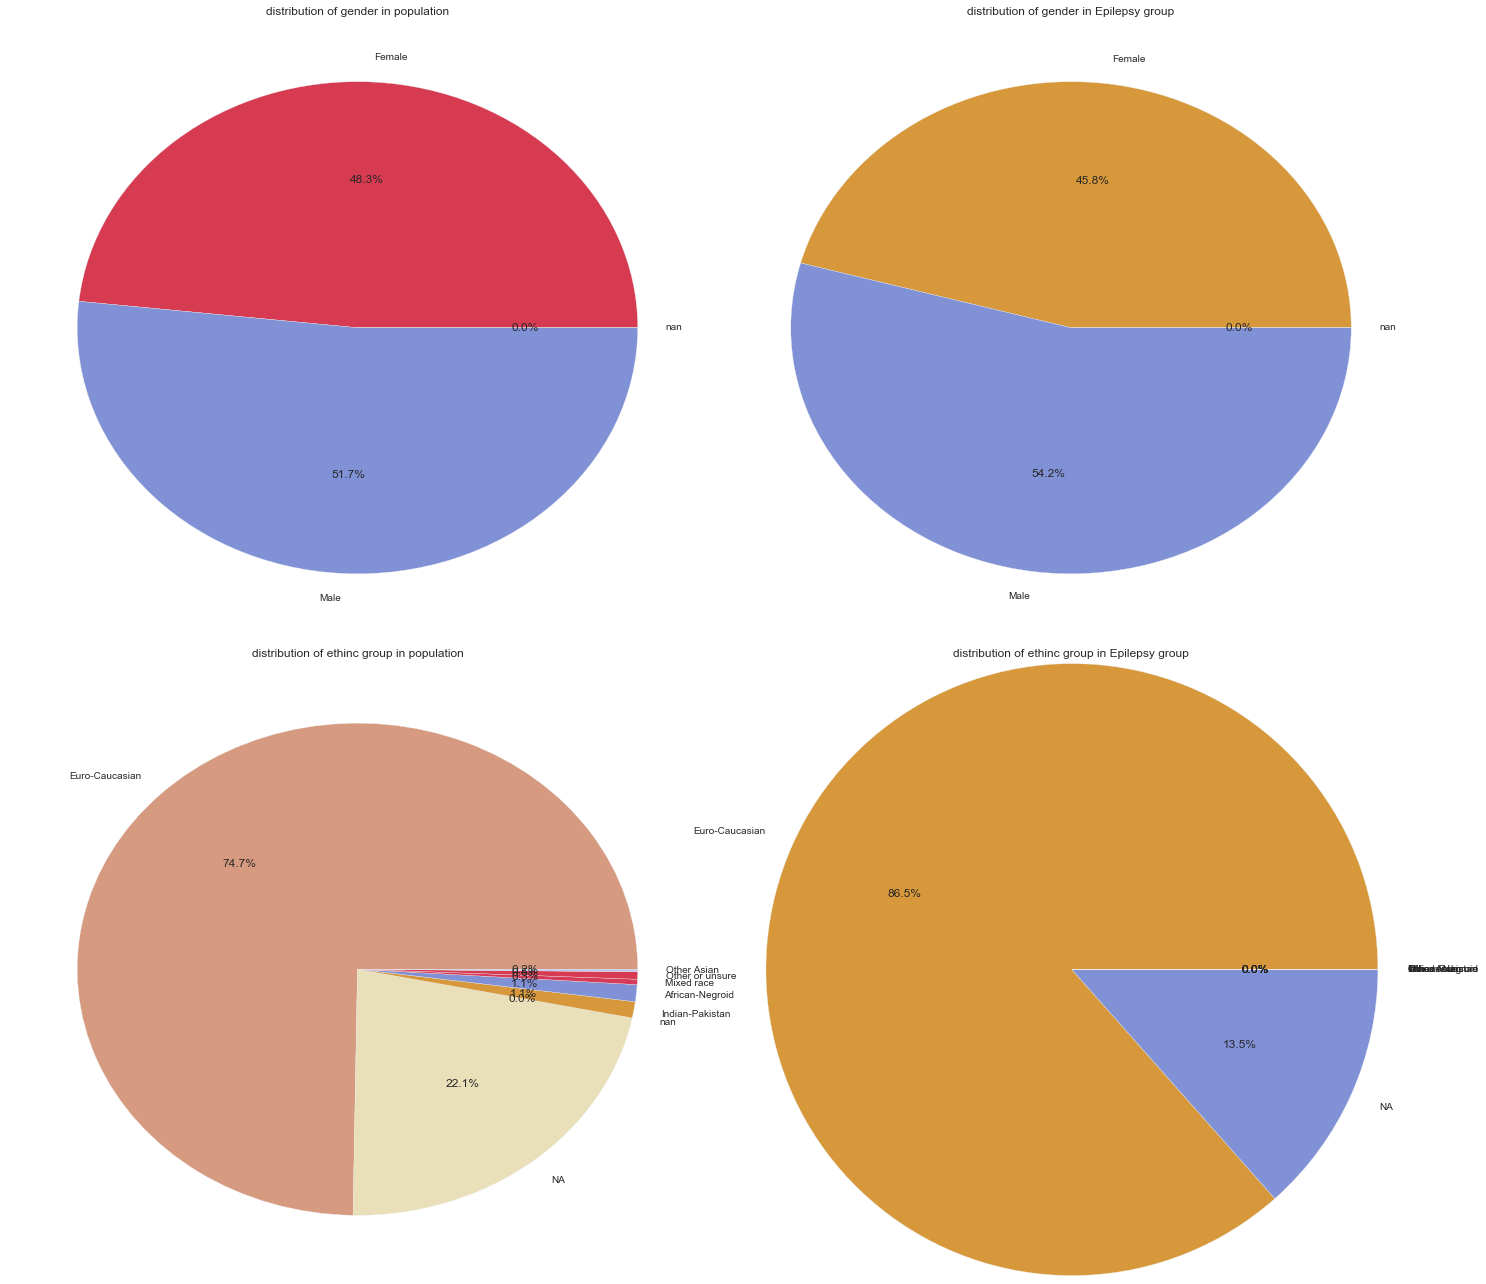

In [106]:
plot_columns = ['Gender']
fig = plt.figure(figsize=(20, 18))


ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('distribution of gender in population')
ax1 = [pie_plot(data_main, 'Gender',)]



ax1 = fig.add_subplot(2, 2, 2)
ax1.set_title('distribution of gender in Epilepsy group')
ax1 = [pie_plot(data_main, 'Gender', 'Epilepsy_identification', 'Epilepsy')]

ax1 = fig.add_subplot(2, 2, 3)
ax1.set_title('distribution of ethinc group in population')
ax1 = [pie_plot(data_main, 'Ethinic_gp',) for x in plot_columns]


ax1 = fig.add_subplot(2, 2, 4)
ax1.set_title('distribution of ethinc group in Epilepsy group')
ax1 = [pie_plot(data_main, 'Ethinic_gp', 'Epilepsy_identification', 'Epilepsy') for x in plot_columns]


plt.tight_layout()
plt.axis('equal')
plt.show();

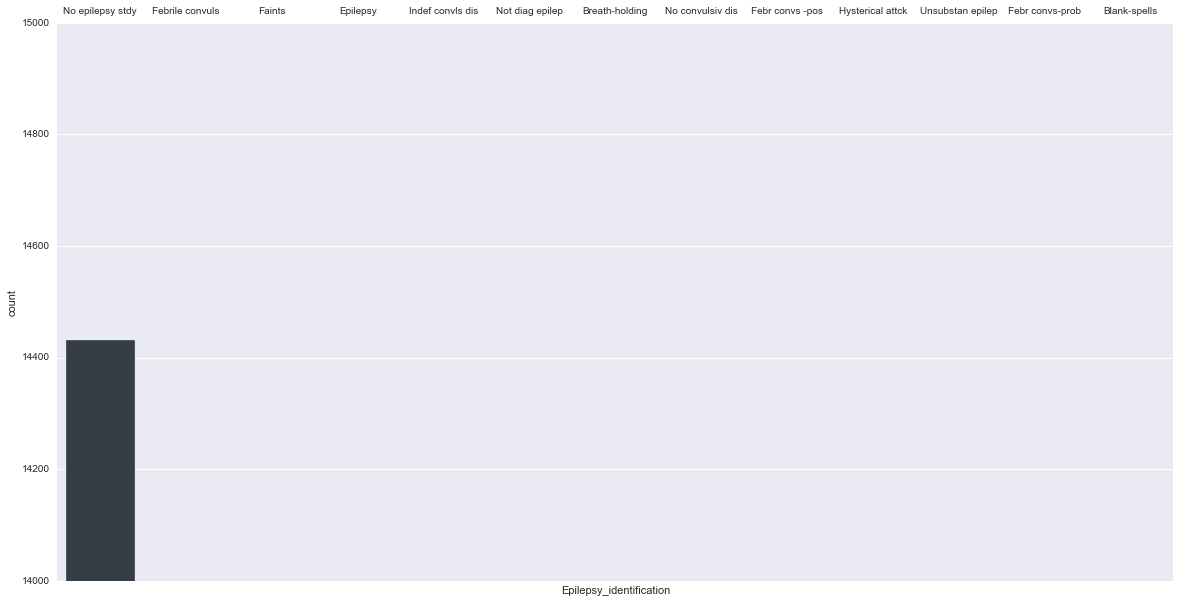

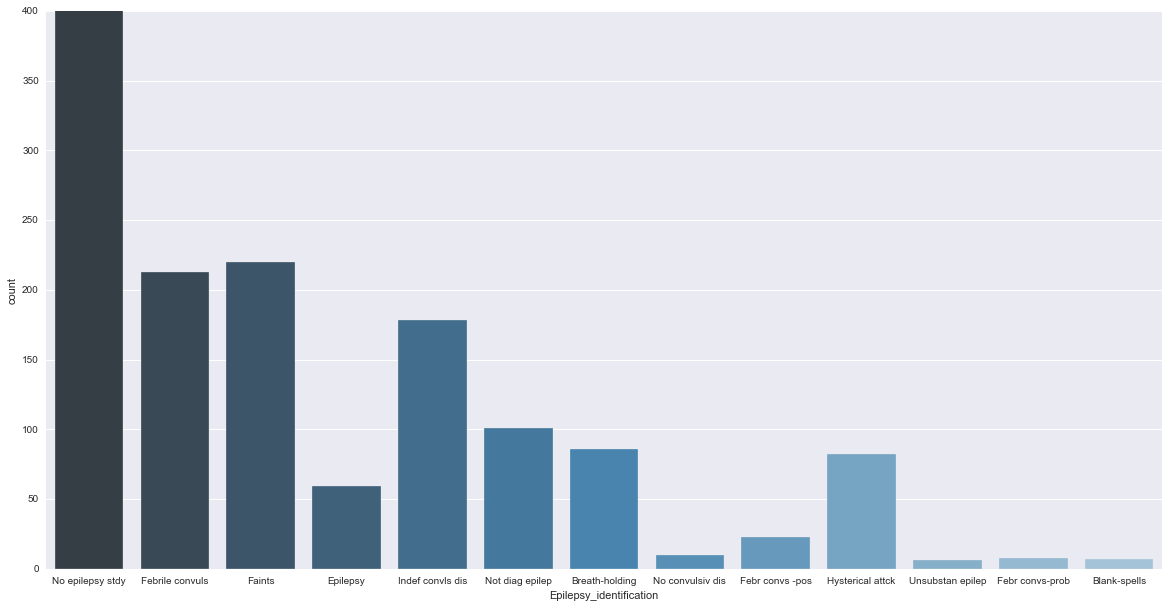

In [96]:
#plot_data = np.isfinite(data_main['2P Age at 1st epilepsy attack'])
#yvals = [100,500,2000,15000]
#fig = plt.figure(figsize=(20, 10))

#f, (ax2, ax3) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
#ax2 = data_main['Epilepsy_identification'].value_counts().plot(kind='bar',)
fig = plt.figure(figsize=(20, 10))
ax2 = sns.countplot(x="Epilepsy_identification", data=data_main, palette="Blues_d");
fig = plt.figure(figsize=(20, 10))
ax3 = sns.countplot(x="Epilepsy_identification", data=data_main, palette="Blues_d");

# zoom-in / limit the view to different portions of the data
ax2.set_ylim(14000., 15000.)  # outliers only
ax3.set_ylim(0, 400.)  # most of the data

# hide the spines between ax and ax2
ax3.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.tick_top()

ax3.xaxis.tick_bottom()


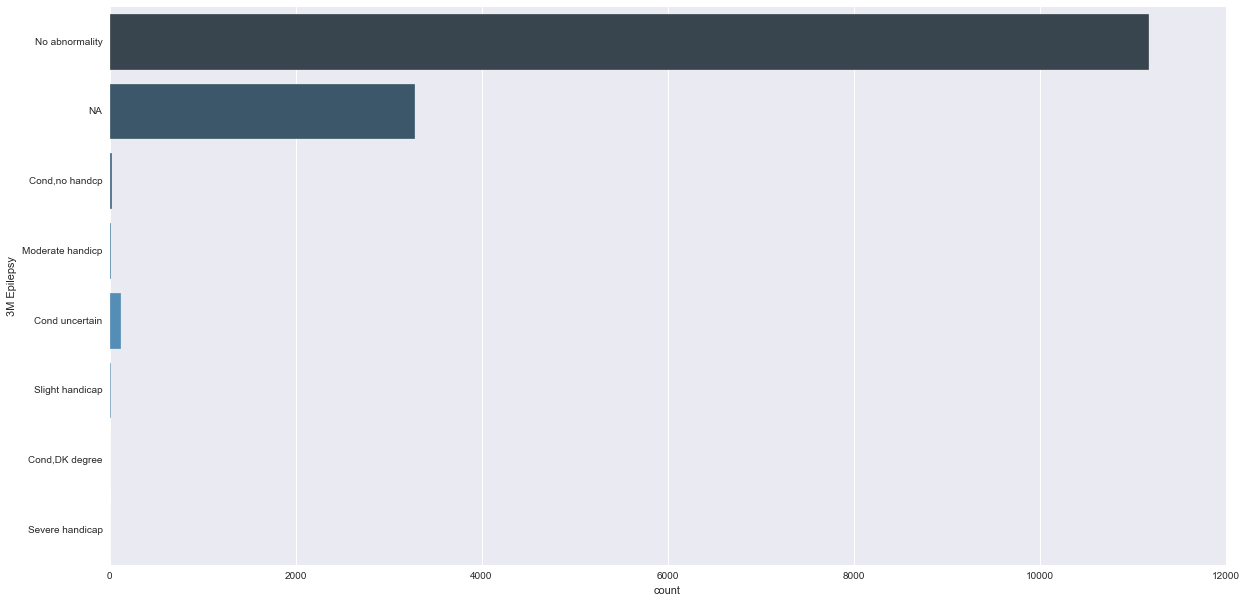

In [97]:
fig = plt.figure(figsize=(20, 10))
sns.countplot(y="3M Epilepsy", data=data_main, palette="Blues_d");

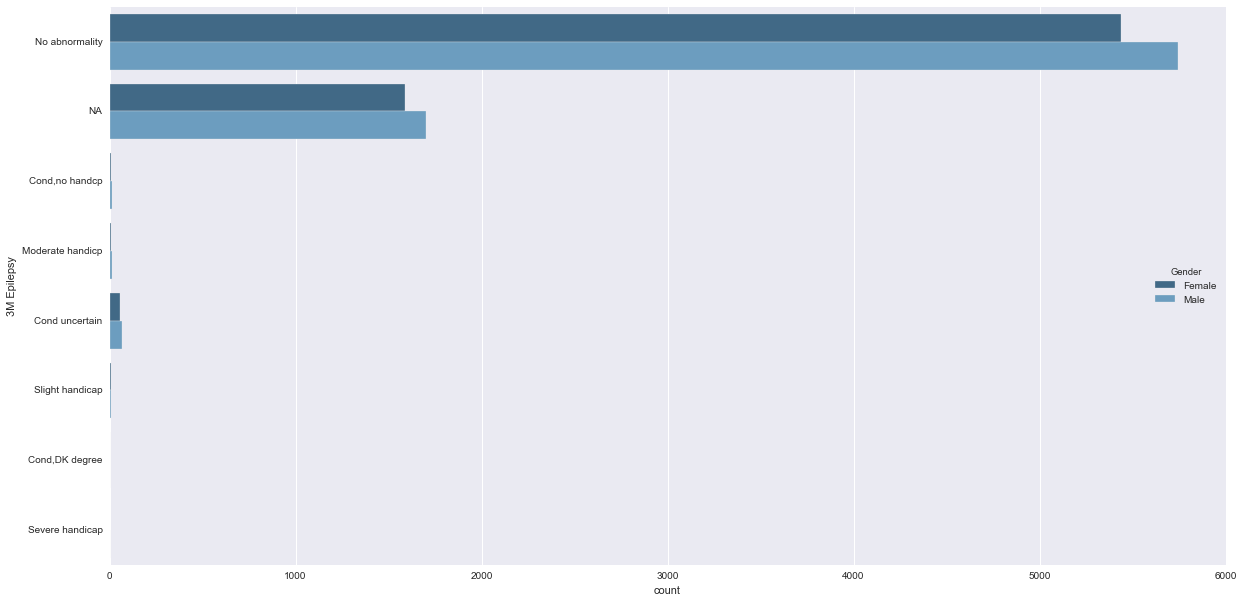

In [98]:
fig = plt.figure(figsize=(20, 10))
sns.countplot(y="3M Epilepsy", hue="Gender", data=data_main, palette="Blues_d");

### Chi-Squared Test of Independence

The chi-squared test of independence tests whether two categorical variables are independent. 

In [100]:
recent_attack = data_main['2P Age at most recent epilepsy attack']
age_first_attack = data_main['2P Age at 1st epilepsy attack']

In [101]:
recent_attack_table = pd.crosstab(index=recent_attack, columns="count")
age_first_attack_table = pd.crosstab(index=age_first_attack, columns="count")

In [102]:
Cross_table = pd.crosstab(recent_attack, age_first_attack, margins = True)
observed = Cross_table.ix[0:13,0:12]   # Get table without totals for later use

In [103]:
age_first_attack.value_counts()

No epilepsy stdy    14633
1                     106
2                      82
10                     75
9                      46
11                     45
3                      43
7                      31
5                      30
8                      29
4                      27
6                      26
Name: 2P Age at 1st epilepsy attack, dtype: int64

In [104]:
recent_attack.value_counts()

No epilepsy stdy    14626
11                    117
10                    112
2                      77
1                      74
3                      57
9                      55
4                      46
5                      36
7                      26
8                      25
6                      22
12                      1
Name: 2P Age at most recent epilepsy attack, dtype: int64

In [105]:
Cross_table

2P Age at 1st epilepsy attack,1,10,11,2,3,4,5,6,7,8,9,No epilepsy stdy,All
2P Age at most recent epilepsy attack,,,,,,,,,,,,,
1,53,0,0,0,0,0,0,0,0,0,0,1,54
10,1,55,0,2,4,4,6,7,6,6,11,4,106
11,1,20,45,5,4,3,3,4,6,9,9,5,114
12,0,0,0,0,0,0,0,0,0,0,0,1,1
2,14,0,0,48,0,0,0,0,0,0,0,2,64
3,12,0,0,5,25,0,0,0,0,0,0,7,49
4,6,0,0,11,3,16,0,0,0,0,0,4,40
5,6,0,0,3,1,2,14,0,0,0,0,2,28
6,4,0,0,1,1,0,3,9,0,0,0,0,18


chi-squared test statistic : 58494.964159487434

P values : 0.00

DF : 132 

As expected, given the low p-value, the test result detect a significant relationship between the variables: '2P Age at most recent epilepsy attack' and '2P Age at 1st epilepsy attack'

In [ ]:
#data_main_mapped.head()

In [ ]:
#data_main_mapped.n553.dtypes

## Epilepsys vs seizures

### Features selection 

In [43]:
epilepsy_response.head()

,epilepsy7,epilepsy11,epilepsy16,epilepsy
0,no,no,no,0
1,no,-1,no,0
2,no,no,no,0
3,no,no,no,0
4,no,no,no,0


In [59]:
# the response variables columns
#response_columns = ['y_epilepsy', 'y_convulsions_epilepsy', 'y_convulsions']
# predictors
#feature_columns = [ x for x in data_main_clean_2.columns if not any(m == x for m in response_columns)]
X_train = data_main_mapped.copy()
# the response variables
y_1 = epilepsy_response['seizure']
y_2 = epilepsy_response['epilepsy']

In [92]:
print y_1.value_counts()
print y_2.value_counts()

0    17143
1     1415
Name: seizure, dtype: int64
0    18194
1      364
Name: epilepsy, dtype: int64


In [60]:
numeric_columns = [x for x,y in zip(X_train.columns, X_train.dtypes) if any([ y == m for m in ['int64', 'float64']]) ]
cat_columns = [x for x,y in zip(X_train.columns, X_train.dtypes) if not any([ y == m for m in ['int64', 'float64']]) ]

In [62]:
data_main_mapped.shape, len(cat_columns), len(numeric_columns)

((18558, 1760), 1512, 248)

In [63]:
cat_columns[10]

'0  inhalational analgesia'

In [64]:
#mask = X_train.apply(lambda x : 'Categorical' if len(x.unique()) < 15 else 'Numeric')
#mask.shape
# cat_columns = mask[(mask == 'Categorical')].index.values
# cat_columns
# len(cat_columns)

In [65]:
#X_train.head()

In [66]:
# Encoding the categorical variables 
X_train_2 = encode_onehot(X_train, cat_columns)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: the 'outtype' keyword is deprecated, use 'orient' instead


In [67]:
X_train_2.shape

(18558, 12256)

In [68]:
#X_train_2.head()

In [69]:
X_train_2 = X_train_2.fillna(0)

In [70]:
X_train_2 = clean_column_names(X_train_2)

In [71]:
X_train_2.shape, y_1.shape

((18558, 12256), (18558,))

In [72]:
#list(y_1.values)

In [73]:
from sklearn.ensemble import ExtraTreesClassifier
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=7)

forest.fit(X_train_2.values, list(y_1.values))
#importances = forest.feature_importances_

feature_importances = zip(X_train_2.columns, forest.feature_importances_)

sorted_feature = sorted(feature_importances, key= lambda x: x[1], reverse=True)
#print sorted_feature[:20]

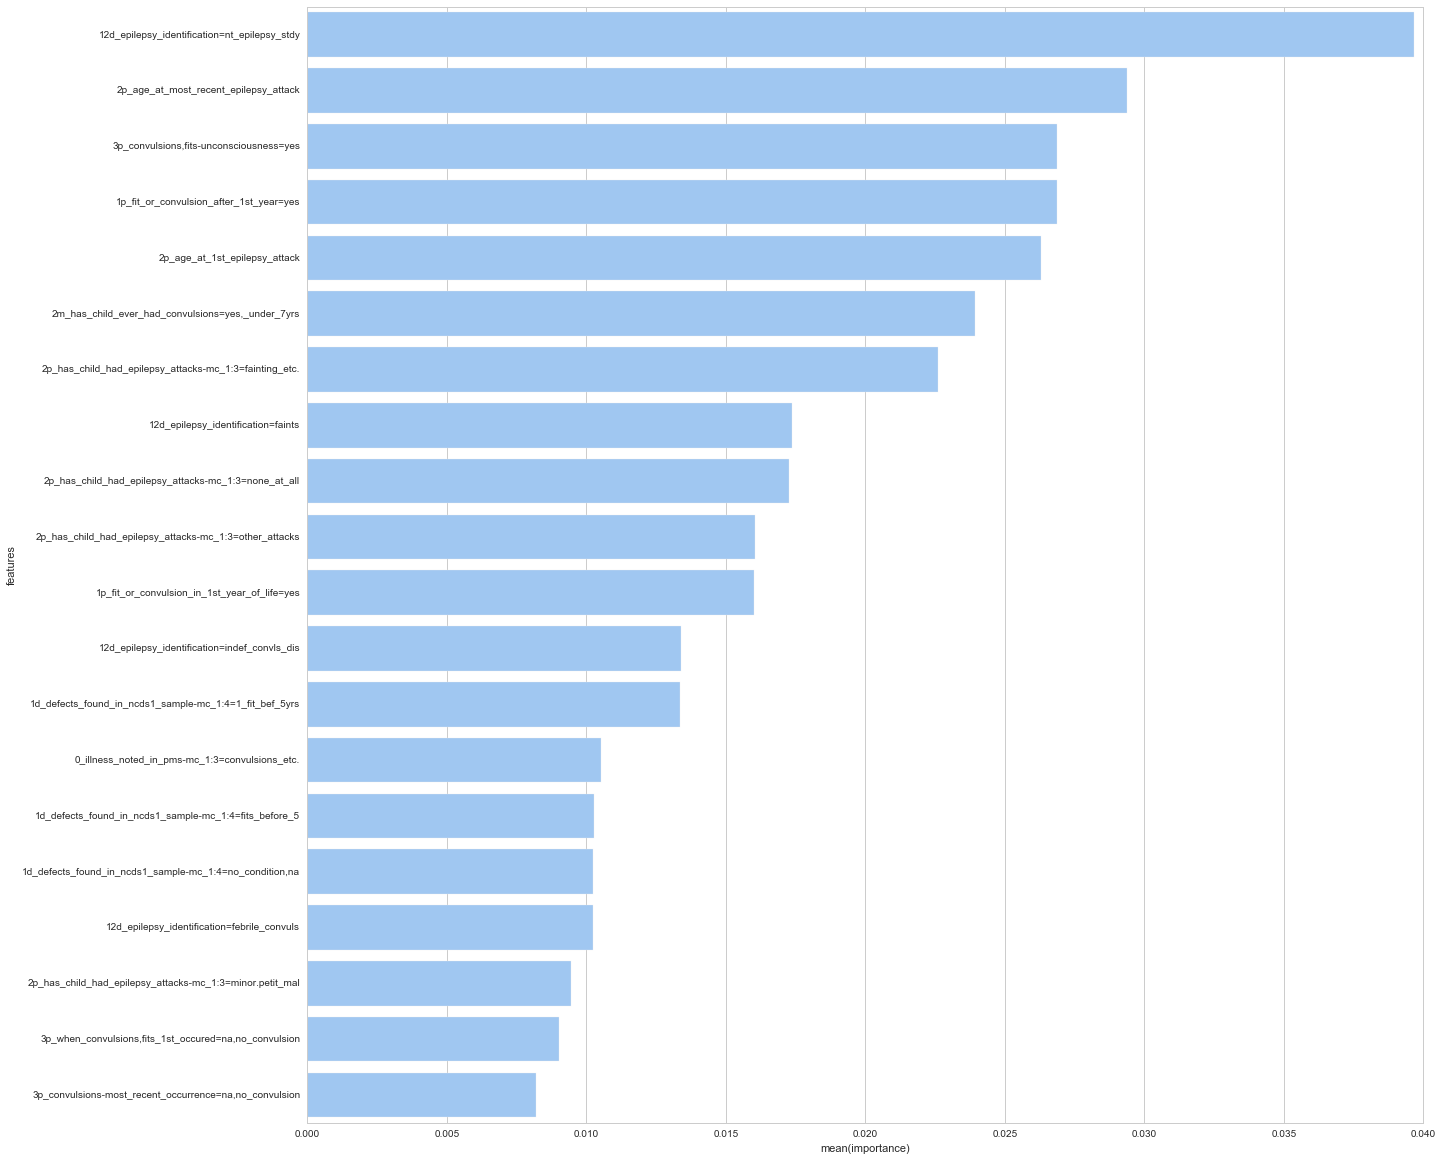

In [74]:
fig = plt.figure(figsize=(20, 20))
sns.set_color_codes("pastel")
sns.barplot(y="features", x="importance", data=pd.DataFrame({'features':[x for x,y in sorted_feature[:20]], 
                                                            'importance': [y for x,y in sorted_feature[:20]]}),
            label="Total", color="b");

In [75]:
from sklearn.ensemble import ExtraTreesClassifier
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=7)

forest.fit(X_train_2.values, list(y_2.values))
#importances = forest.feature_importances_

feature_importances = zip(X_train_2.columns, forest.feature_importances_)

sorted_feature = sorted(feature_importances, key= lambda x: x[1], reverse=True)
#print sorted_feature[:20]

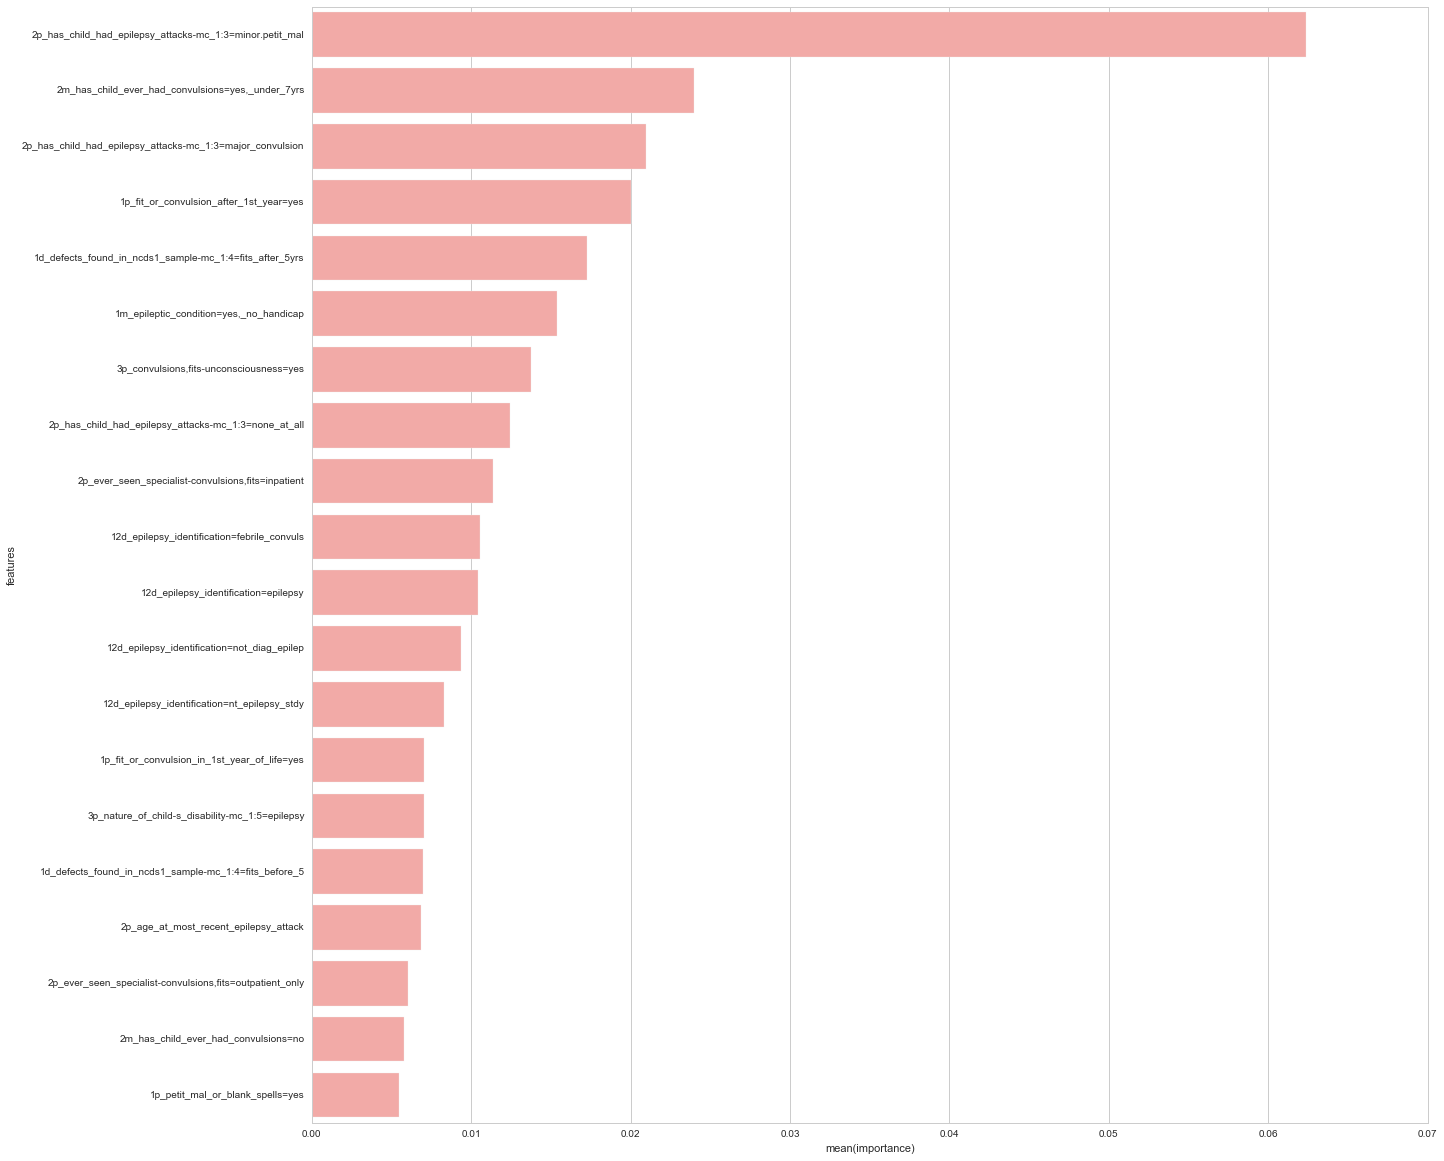

In [76]:
fig = plt.figure(figsize=(20, 20))
sns.set_color_codes("pastel")
sns.barplot(y="features", x="importance", data=pd.DataFrame({'features':[x for x,y in sorted_feature[:20]], 
                                                            'importance': [y for x,y in sorted_feature[:20]]}),
            label="Total", color="r");

### Baseline model

In [77]:
print(__doc__)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler

sns.set()

Automatically created module for IPython interactive environment


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Logistic Regression

In [78]:
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import metrics
from matplotlib import pyplot

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [80]:
test_size = 0.33
X_train_3, X_test_3, y_train_3, y_test_3 = cross_validation.train_test_split(X_train_2\
                                                                             [[x for x,y in sorted_feature[:20]]],
                                                                             list(y_1.values))

In [85]:
model = LogisticRegression(class_weight='balanced',)
model.fit(X_train_3, y_train_3)
y_pred = model.predict(X_test_3)
target_names = ['No Epilepsy', 'Epilepsy']
print(classification_report(y_test_3, y_pred, target_names=target_names))
print 'F1 Score is:', metrics.f1_score(y_test_3, y_pred, pos_label=1)
print "Cohen's Kappa Score is:", metrics.cohen_kappa_score(y_test_3, y_pred,)

             precision    recall  f1-score   support

No Epilepsy       0.99      1.00      0.99      4271
   Epilepsy       0.99      0.84      0.91       369

avg / total       0.99      0.99      0.99      4640

F1 Score is: 0.908823529412
Cohen's Kappa Score is: 0.901670789922


In [87]:
test_size = 0.33
X_train_4, X_test_4, y_train_4, y_test_4 = cross_validation.train_test_split(X_train_2\
                                                                             [[x for x,y in sorted_feature[:20]]],
                                                                             list(y_2.values))

In [88]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_4, y_train_4)
y_pred = model.predict(X_test_4)
target_names = ['Convulsions', 'Convulsions_and_Epilepsy']
print(classification_report(y_test_4, y_pred, target_names=target_names))
print 'Accuracy Score on test is:', metrics.accuracy_score(y_test_4, y_pred,)
print "Cohen's Kappa Score is:", metrics.cohen_kappa_score(y_test_4, y_pred,)

                          precision    recall  f1-score   support

             Convulsions       1.00      0.99      1.00      4535
Convulsions_and_Epilepsy       0.72      0.95      0.82       105

             avg / total       0.99      0.99      0.99      4640

Accuracy Score on test is: 0.990732758621
Cohen's Kappa Score is: 0.818377118721


The accuracy is high because we are overfitting.

#### LDA

In [89]:
model = LinearDiscriminantAnalysis()
model.fit(X_train_3, y_train_3)
y_pred = model.predict(X_test_3)
target_names = ['No Epilepsy', 'Epilepsy']
print(classification_report(y_test_3, y_pred, target_names=target_names))
print 'F1 Score is:', metrics.f1_score(y_test_3, y_pred, pos_label=1)
print "Cohen's Kappa Score is:", metrics.cohen_kappa_score(y_test_3, y_pred,)

             precision    recall  f1-score   support

No Epilepsy       0.98      1.00      0.99      4271
   Epilepsy       1.00      0.76      0.87       369

avg / total       0.98      0.98      0.98      4640

F1 Score is: 0.865030674847
Cohen's Kappa Score is: 0.855021932051


In [90]:
model = LinearDiscriminantAnalysis()
model.fit(X_train_4, y_train_4)
y_pred = model.predict(X_test_4)
target_names = ['No_Convulsions_and_No_Epilepsy', 'Convulsions_and_Epilepsy', 'Convulsions_and_No_Epilepsy']
print(classification_report(y_test_4, y_pred, target_names=target_names))
print 'Accuracy Score on test is:', metrics.accuracy_score(y_test_4, y_pred,)
print "Cohen's Kappa Score is:", metrics.cohen_kappa_score(y_test_4, y_pred,)

                                precision    recall  f1-score   support

No_Convulsions_and_No_Epilepsy       1.00      1.00      1.00      4535
      Convulsions_and_Epilepsy       1.00      0.92      0.96       105

                   avg / total       1.00      1.00      1.00      4640

Accuracy Score on test is: 0.998275862069
Cohen's Kappa Score is: 0.959516201154


#### Handling the imbalanced classes

In [132]:
#SMOTE: Synthetic Minority Over-sampling Technique
# Apply SMOTE + ENN
sm = SMOTEENN(0.1)
X_resampled, y_resampled = sm.fit_sample(X_train_2.values, list(y_2.values))

#### Handling the missing values

### Appendices

#### Dealing with missing values

In [ ]:
#missing_df = pd.read_csv('./dataset/dataset_1_missing.txt')
#full_df = pd.read_csv('./dataset/dataset_1_full.txt')

#no_y_ind = missing_df[missing_df['y'].isnull()].index
#with_y_ind = missing_df[missing_df['y'].notnull()].index

#number of neighbours
#k=3

#predicted_knn, r_knn = fill_knn(missing_df, full_df, no_y_ind, with_y_ind, k)
#print 'R^2 value of KNN fit, for k=', k, ': ', r_knn

#### PCA, Resampling and Visuation

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


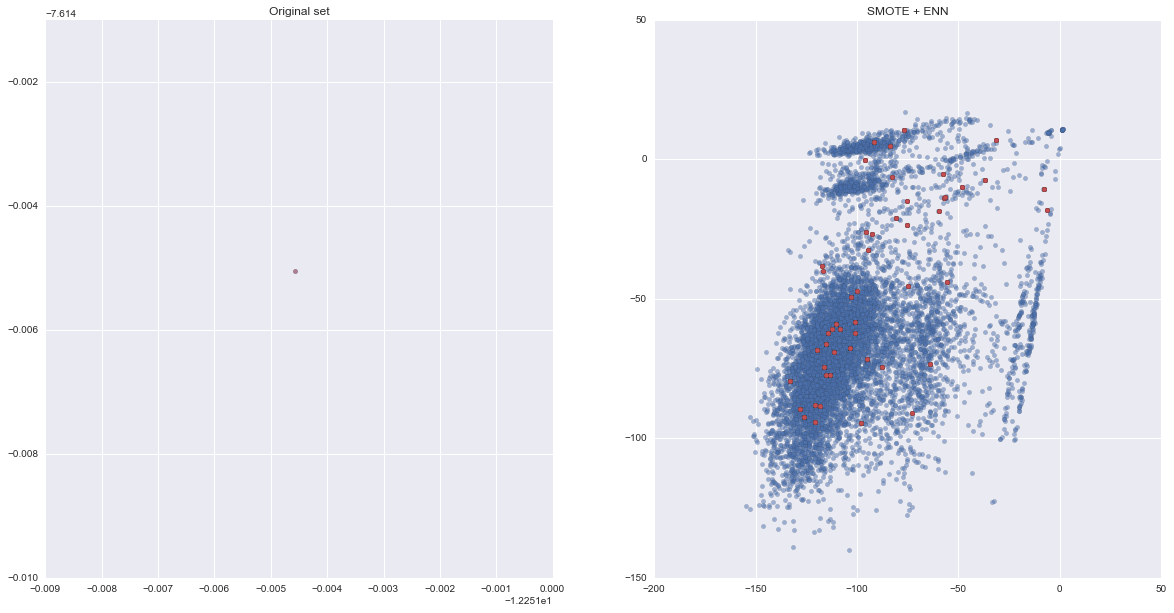

In [129]:
from sklearn import preprocessing
X_train_2_pre = preprocessing.scale(X_train_2)

# Define some color for the plotting
almost_black = '#262626'
palette = sns.color_palette()

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=3)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X_train_2_pre)

# Apply SMOTE + ENN
sm = RandomOverSampler(0.1)
X_resampled, y_resampled = sm.fit_sample(X_train_2.values, list(y_2.values))
X_res_vis = pca.transform(X_resampled)

#fig = plt.figure(figsize=(15, 5))
# Two subplots, unpack the axes array immediately
#f, (ax1, ax2) = plt.subplots(1, 2, projection='3d')
fig, ((ax1, ax2)) =  plt.subplots(1, 2, figsize=(20, 10))
ax1.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
ax1.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
ax1.set_title('Original set')


ax2.scatter(X_res_vis[y_resampled == 0, 0], X_res_vis[y_resampled == 0, 1],
            label="Class #0", alpha=.5, edgecolor=almost_black,
            facecolor=palette[0], linewidth=0.15)
ax2.scatter(X_res_vis[y_resampled == 1, 0], X_res_vis[y_resampled == 1, 1],
            label="Class #1", alpha=.5, edgecolor=almost_black,
            facecolor=palette[2], linewidth=0.15)
ax2.set_title('SMOTE + ENN')

plt.show()

Pos. = 353	Variable = n1842	Variable label = 12D Epilepsy identification
This variable is  numeric, the SPSS measurement level is ORDINAL
SPSS user missing values = -1.0 thru -2.0
	Value label information for n1842
	Value = 1.0	Label = No convulsiv dis
	Value = 2.0	Label = Indef convls dis
	Value = 3.0	Label = Faints
	Value = 4.0	Label = Hysterical attck
	Value = 5.0	Label = Epilepsy
	Value = 6.0	Label = Unsubstan epilep
	Value = 7.0	Label = Febr convs-prob
	Value = 8.0	Label = Febr convs -pos
	Value = 9.0	Label = Not diag epilep
	Value = 10.0	Label = Febrile convuls
	Value = 11.0	Label = Breath-holding
	Value = 12.0	Label = Blank-spells
	Value = -1.0	Label = Nt epilepsy stdy
	Value = -2.0	Label = No NCDS1,NCDS2

In [ ]:
Counter(data_main["Epilepsy_identification"])